# Testing for Translational Invariance

https://en.wikipedia.org/wiki/Translational_symmetry

In [7]:
import torch
import torch.optim as optim
import torchvision
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from models import *
from utils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# check if CUDA is available
device = torch.device("cpu")
use_cuda = False
if torch.cuda.is_available():
    print('CUDA is available!')
    device = torch.device("cuda")
    use_cuda = True
else:
    print('CUDA is not available.')

CUDA is available!


In [9]:
data_dir = "C:\data\MNIST"
batch_size_test = 1

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=False, download=True,
                         transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor()
                         ])),
    batch_size=batch_size_test, shuffle=False, pin_memory=True)

inputs, targets = next(iter(test_loader))
inputs = inputs.to(device)
targets = targets.to(device)

## Locate digit with bounding box

In [12]:
def extract_min_img(img):
    img = torch.squeeze(img) * 255
    img_np = img.cpu().numpy().astype(np.uint8)
    retVal, threshold_image = cv2.threshold(img_np,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(threshold_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = np.squeeze(np.array(contours), 0)
    x,y,w,h = cv2.boundingRect(contours)
    bounded_img = img_np[y:y+h, x:x+w]
    return bounded_img

In [13]:
img = torch.squeeze(inputs[0]) * 255
img_np = img.cpu().numpy().astype(np.uint8)

In [14]:
retVal, threshold_image = cv2.threshold(img_np,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
contours, hierarchy = cv2.findContours(threshold_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = np.squeeze(np.array(contours), 0)

x,y,w,h = cv2.boundingRect(contours)
bounded_img = img_np[y:y+h, x:x+w]

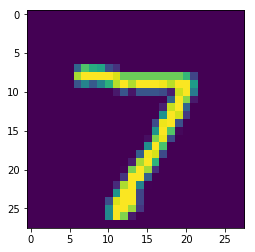

In [15]:
plt.imshow(img_np)
plt.show()

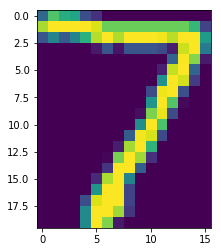

In [16]:
plt.imshow(bounded_img)
plt.show()

## Generate new images with translations of the original

In [17]:
def pad_img(target_img, original_img, offsets=[0,0]):
    """
    bounded_img: Image to be padded / inserted into a blank array of zeros
    original_img: Reference img with the desired shape
    offsets: list of offsets (number of elements must be equal to the dimension of the array)
    """
    # Create an array of zeros with the reference shape
    result = np.zeros(original_img.shape)
    # Create a list of slices from offset to offset + shape in each dimension
    insertHere = [slice(offsets[dim], offsets[dim] + target_img.shape[dim]) for dim in range(target_img.ndim)]
    # Insert the array in the result at the specified offsets
    result[tuple(insertHere)] = target_img
    return result

In [18]:
# padding with numpy function
# plt.imshow(np.pad(bounded_img, [(4, ), (6, )], mode='constant'))

In [19]:
target_shape = img_np.shape
bounded_shape = bounded_img.shape

max_dim0_offset = target_shape[0] - bounded_shape[0]
max_dim1_offset = target_shape[1] - bounded_shape[1]

max_offsets = [max_dim0_offset, max_dim1_offset]

y_true = targets[0].repeat(max_dim0_offset * max_dim1_offset)

In [20]:
# # random offset for testing
# dim0_offset = int(np.random.uniform(0,max_dim0_offset))
# dim1_offset = int(np.random.uniform(0,max_dim1_offset))
# offsets = [dim0_offset, dim1_offset]

# print('random offsets', offsets)
# plt.imshow(pad_img(bounded_img, img_np, offsets))

In [21]:
def generate_all_offsets(target_img, original_img, max_offsets):
    offset_imgs = []
    for dim0 in range(max_offsets[0]):
        for dim1 in range(max_offsets[1]):
            offsets = [dim0, dim1]
            offset_img = pad_img(target_img, original_img, offsets)
            offset_imgs.append(offset_img)
    return np.array(offset_imgs)

In [22]:
all_offsets = generate_all_offsets(bounded_img, img_np, max_offsets)

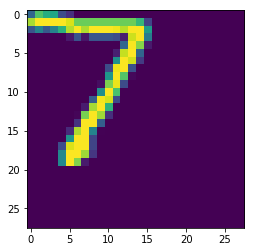

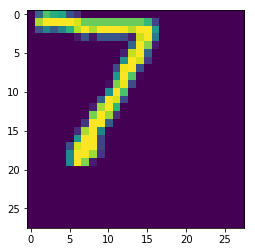

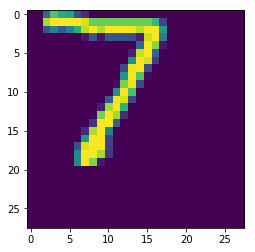

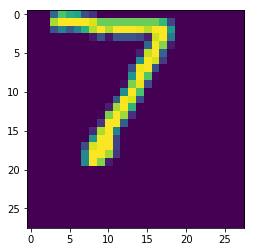

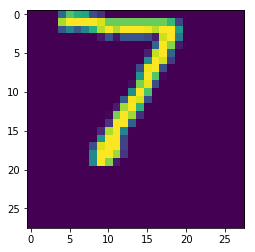

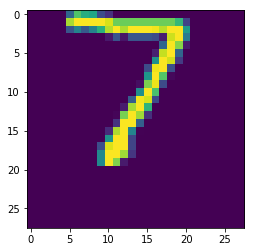

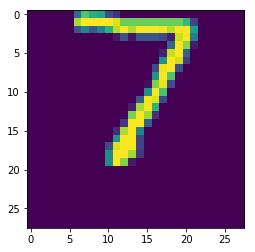

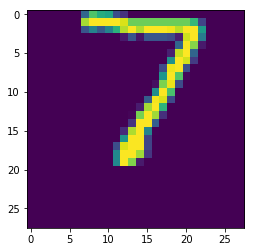

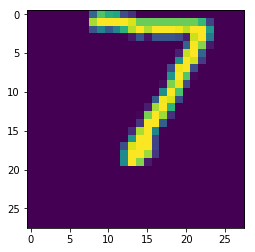

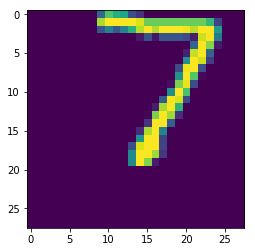

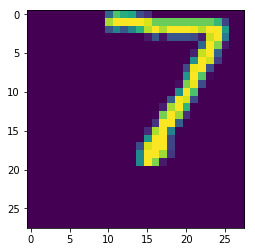

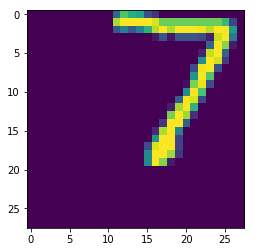

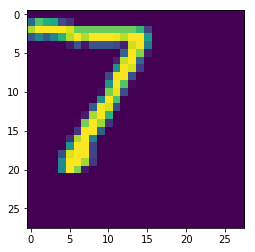

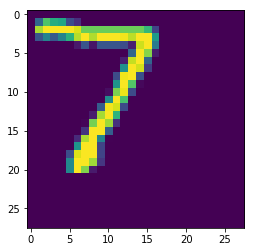

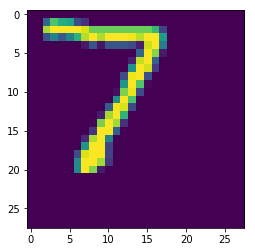

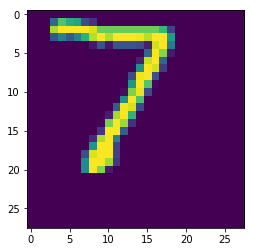

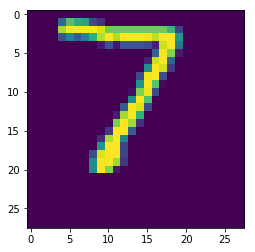

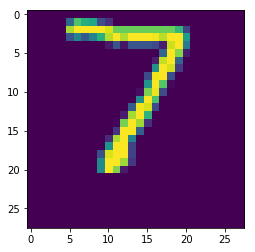

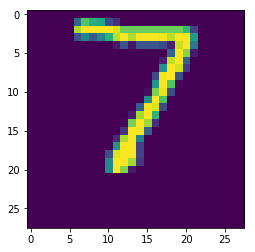

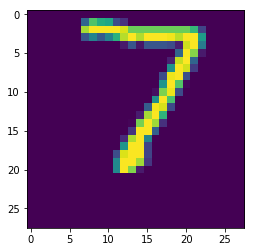

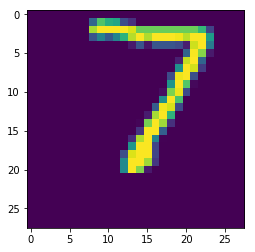

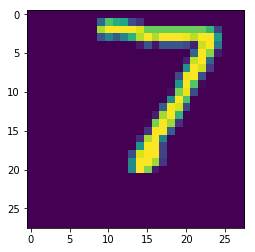

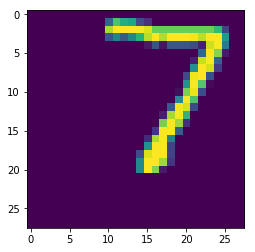

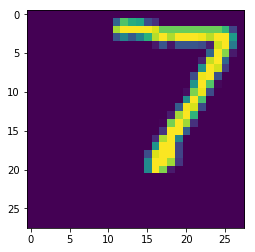

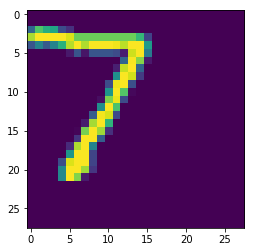

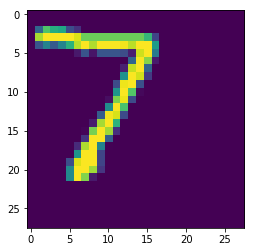

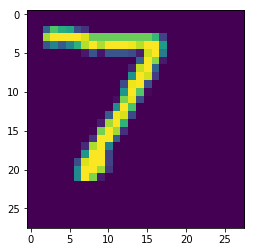

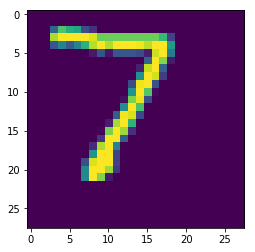

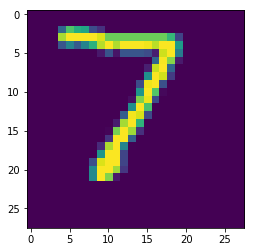

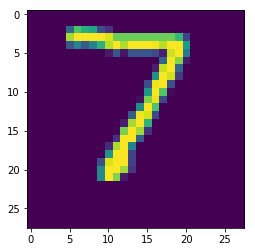

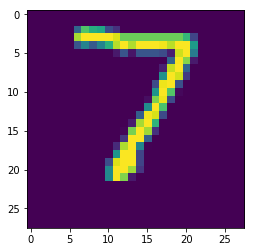

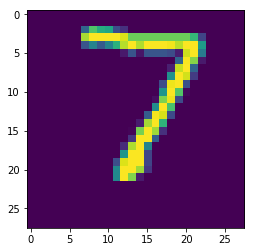

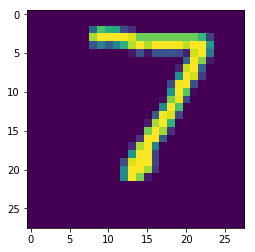

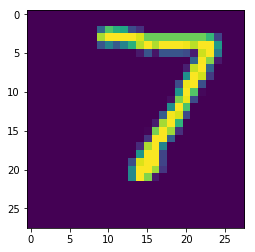

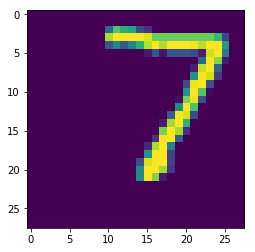

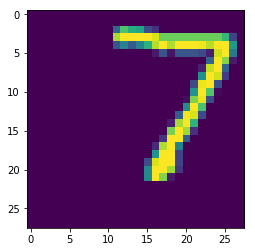

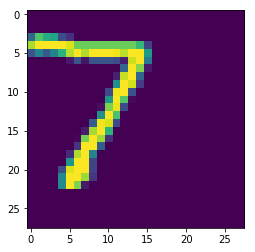

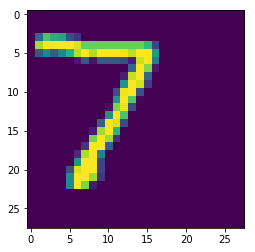

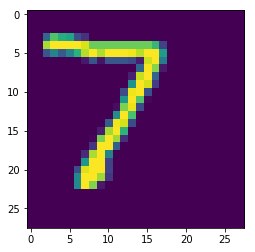

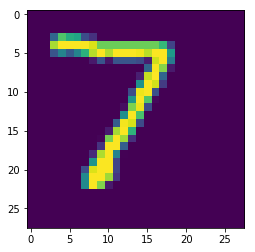

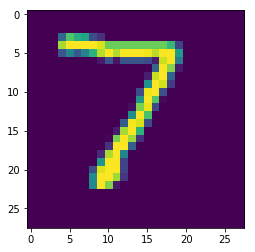

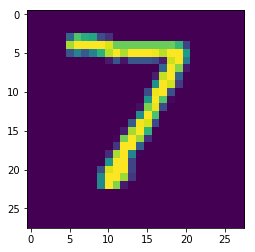

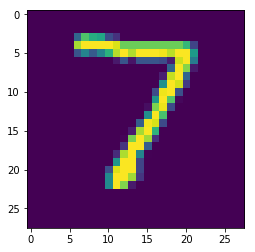

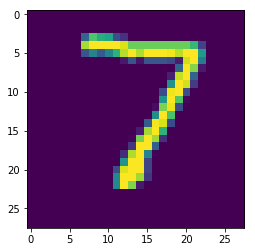

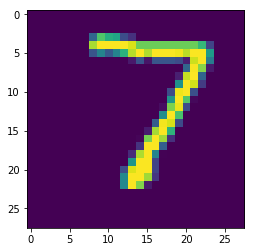

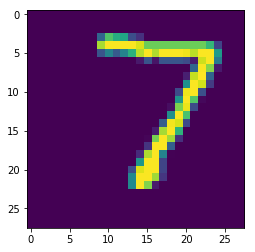

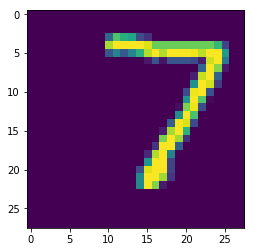

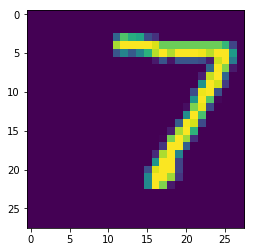

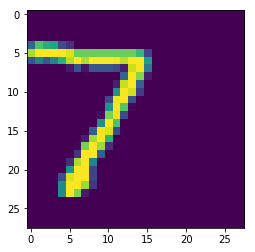

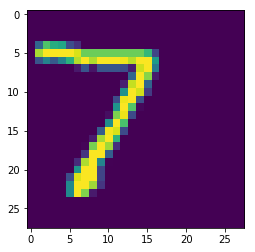

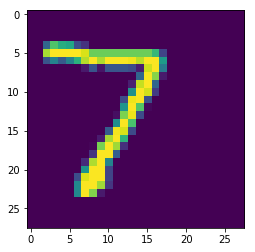

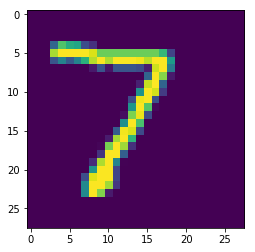

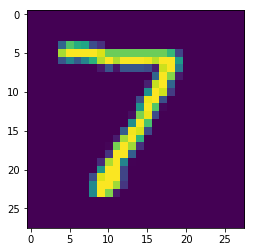

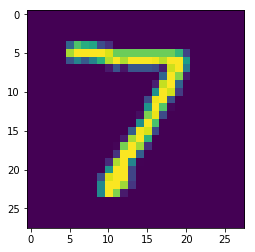

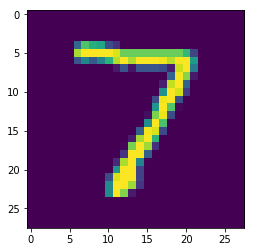

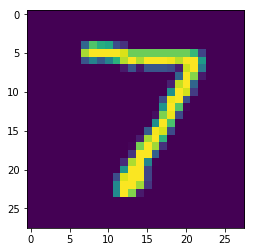

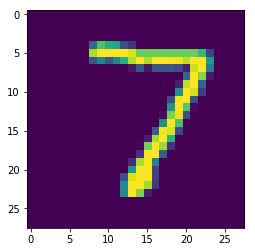

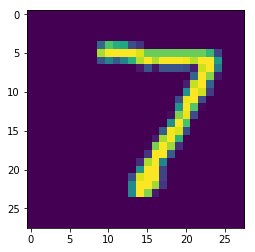

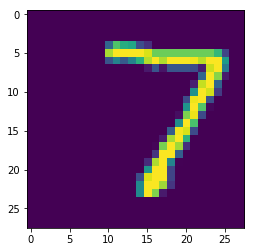

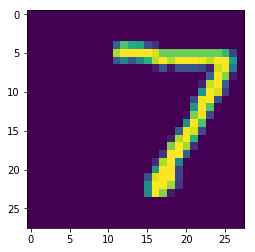

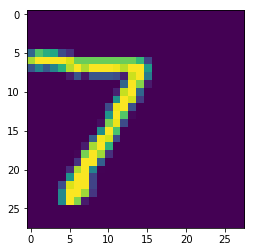

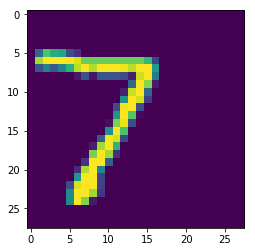

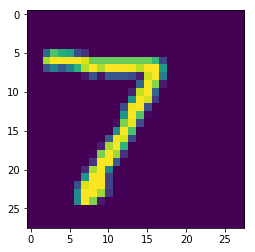

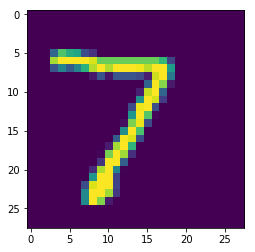

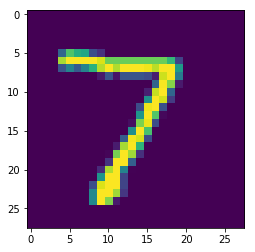

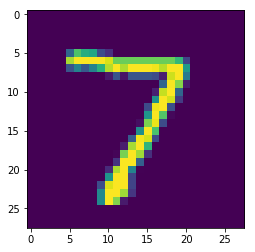

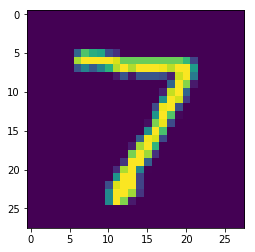

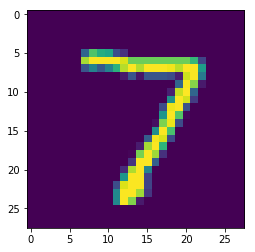

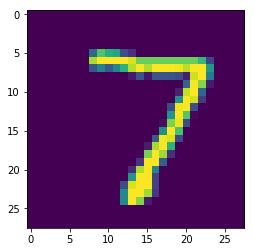

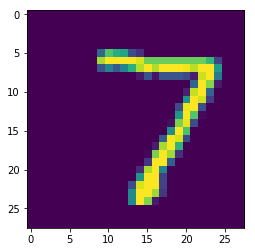

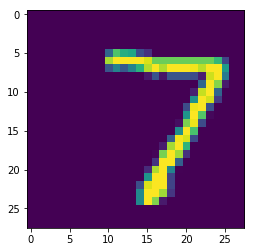

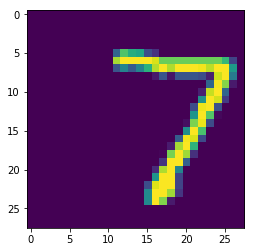

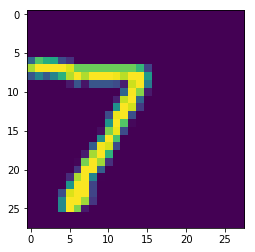

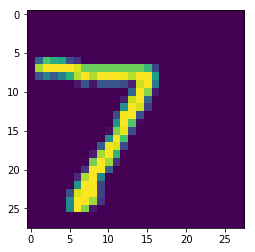

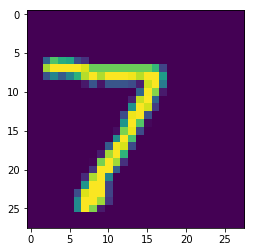

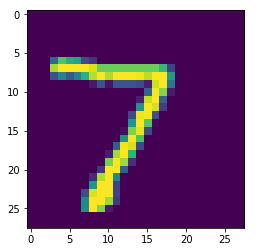

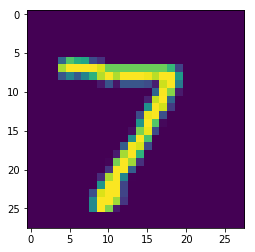

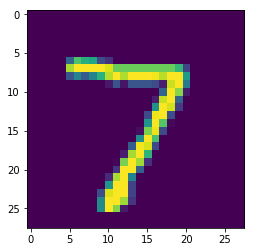

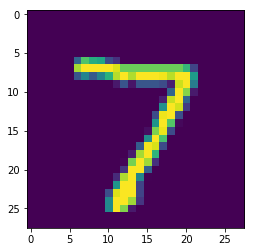

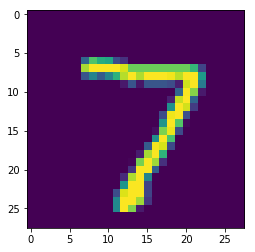

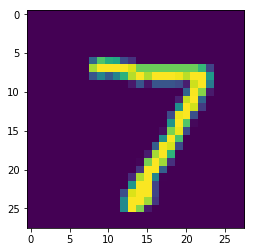

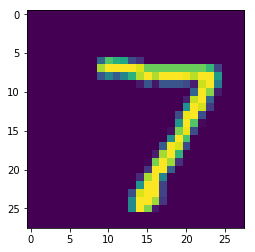

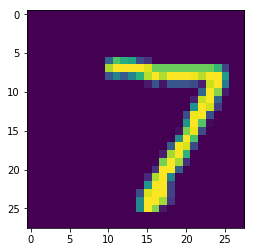

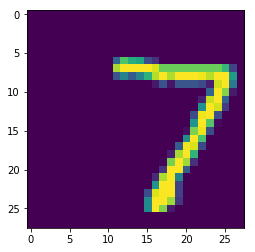

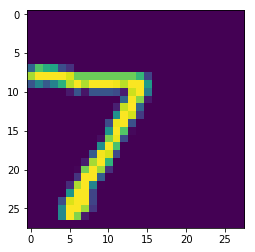

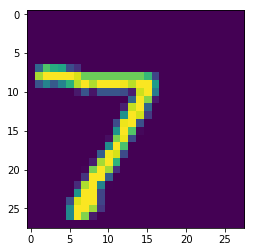

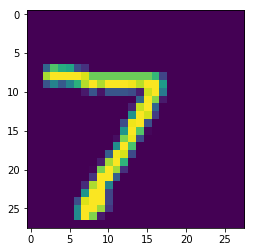

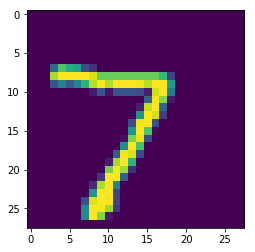

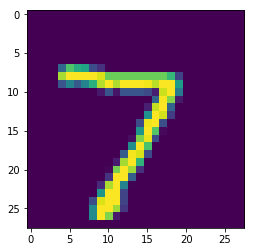

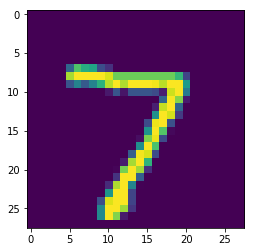

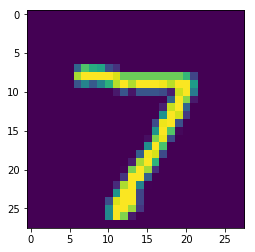

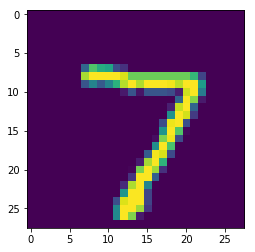

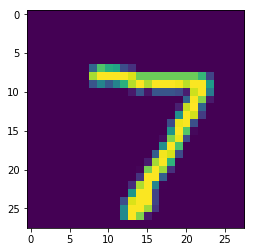

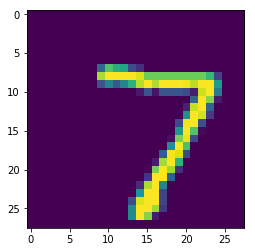

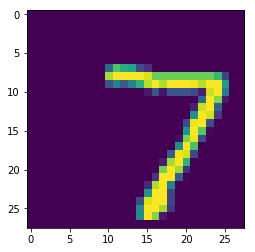

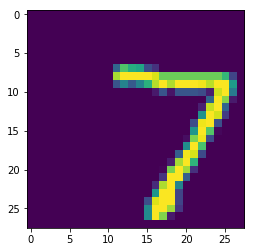

In [23]:
for img in all_offsets:
    plt.imshow(img)
    plt.show()

In [24]:
def np_to_pytorch_imgs(inputs, channel_first=True):
    if channel_first:
        if len(inputs.shape) == 3: 
            inputs = np.expand_dims(inputs, 1)
        elif len(inputs.shape) == 2:
            inputs = np.expand_dims(inputs, 0)
    else:
        inputs = np.expand_dims(inputs, -1)
        
    inputs_torch = torch.from_numpy(inputs).to(torch.float)
    inputs_torch /= 255
    return inputs_torch

In [25]:
input_offsets = np_to_pytorch_imgs(all_offsets).to(device)

## Test some DNNs

In [26]:
## DenseNet5
fcnet5 = FCNet5().to(device)
fcnet5, _ = get_pretrained_weights(fcnet5) 

## DenseNet10
fcnet10 = FCNet10().to(device) 
fcnet10, _ = get_pretrained_weights(fcnet10)

## Conv1DNet
conv1dnet = Conv1DNet().to(device)
conv1dnet, _ = get_pretrained_weights(conv1dnet)

## Conv2DNet
conv2dnet = Conv2DNet().to(device)
conv2dnet, _ = get_pretrained_weights(conv2dnet)

loading model pretrained_models/mnist\model_FCNet5_2019-10-01 19.54.00.177928_97.96.pth
loading model pretrained_models/mnist\model_FCNet10_2019-10-01 20.00.52.119894_97.92.pth
loading model pretrained_models/mnist\model_Conv1DNet_2019-10-02 00.20.02.430722_98.17.pth
loading model pretrained_models/mnist\model_Conv2DNet_2019-07-25 16.16.26.580052_98.82.pth


In [27]:
for model in [fcnet5, fcnet10, conv1dnet, conv2dnet]:
    model_type = model.__class__.__name__
    y_pred = torch.argmax(model(input_offsets), dim=1)
    acc = y_pred.eq(y_true.data).sum().float() / len(y_true)
    print('model_type:', model_type, '\t', 'acc:', acc.item())

model_type: FCNet5 	 acc: 0.2708333432674408
model_type: FCNet10 	 acc: 0.28125
model_type: Conv1DNet 	 acc: 0.4166666865348816
model_type: Conv2DNet 	 acc: 0.6458333730697632


## Larger Test

In [ ]:
def generate_all_translations(inputs, targets):
    
    new_inputs = []
    new_targets = []
    
    for i, (instance, label) in enumerate(zip(inputs, targets)):
        #print(i)
        
        # Locate digit with bounding box
        img = torch.squeeze(instance) * 255
        img_np = img.cpu().numpy().astype(np.uint8)
        retVal, threshold_image = cv2.threshold(img_np,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        contours, hierarchy = cv2.findContours(threshold_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(np.array(contours).shape) < 4:
            print("contours could not find a suitable rectangle to extract. Skipping image #", i)
            continue
        contours = np.squeeze(np.array(contours), 0)
        x,y,w,h = cv2.boundingRect(contours)
        bounded_img = img_np[y:y+h, x:x+w]
        
        # Generate new images with translations of the original
        target_shape = img_np.shape
        bounded_shape = bounded_img.shape
        max_dim0_offset = target_shape[0] - bounded_shape[0]
        max_dim1_offset = target_shape[1] - bounded_shape[1]
        max_offsets = [max_dim0_offset, max_dim1_offset]

        y_true = label.repeat(max_dim0_offset * max_dim1_offset)
        
        all_offsets_for_X = generate_all_offsets(bounded_img, img_np, max_offsets)
        all_offsets_for_X = np_to_pytorch_imgs(all_offsets_for_X).to(device)
        
        new_inputs.append(all_offsets_for_X)
        new_targets.append(y_true)
        
        i+=1
        
    new_inputs = torch.cat(new_inputs, 0)
    new_targets = torch.cat(new_targets, 0)
    
    return new_inputs, new_targets

# Final Run

In [19]:
## DenseNet5
fcnet5 = FCNet5().to(device)
fcnet5 = get_pretrained_weights(fcnet5) 

## DenseNet10
fcnet10 = FCNet10().to(device) 
fcnet10 = get_pretrained_weights(fcnet10)

## Conv1DNet
conv1dnet = Conv1DNet().to(device)
conv1dnet = get_pretrained_weights(conv1dnet)

## Conv2DNet
conv2dnet = Conv2DNet().to(device)
conv2dnet = get_pretrained_weights(conv2dnet)

loading model pretrained_models/mnist\model_FCNet5_2019-10-01 19.54.00.177928_97.96.pth
loading model pretrained_models/mnist\model_FCNet10_2019-10-01 20.00.52.119894_97.92.pth
loading model pretrained_models/mnist\model_Conv1DNet_2019-10-02 00.20.02.430722_98.17.pth
loading model pretrained_models/mnist\model_Conv2DNet_2019-07-25 16.16.26.580052_98.82.pth


In [56]:
data_dir = "C:\data\MNIST"
batch_size_test = 100

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=False, download=True,
                         transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor()
                         ])),
    batch_size=batch_size_test, shuffle=False, pin_memory=True)

inputs, targets = next(iter(test_loader))
inputs = inputs.to(device)
targets = targets.to(device)

In [57]:
new_inputs, new_targets = generate_all_translations(inputs, targets)

could not generate bounded box for image # 8
could not generate bounded box for image # 59


In [58]:
inputs = inputs.cpu()
targets = targets.cpu()

new_inputs = new_inputs.cpu()
new_targets = new_targets.cpu()

In [61]:
for model in [fcnet5, fcnet10, conv1dnet, conv2dnet]:
    model.cpu()
    model.eval()
    model_type = model.__class__.__name__    
    orig_acc = get_accuracy(model, inputs, targets) 
    new_acc = get_accuracy(model, new_inputs, new_targets) 
    print("model_type: {} \t orig_acc: {:.4f} \t new_acc: {:.4f}".format(model_type, orig_acc.item(), new_acc.item()))

model_type: FCNet5 	 orig_acc: 1.0000 	 new_acc: 0.3075
model_type: FCNet10 	 orig_acc: 1.0000 	 new_acc: 0.3585
model_type: Conv1DNet 	 orig_acc: 0.9900 	 new_acc: 0.3841
model_type: Conv2DNet 	 orig_acc: 1.0000 	 new_acc: 0.4842


# Training with Augmentation

In [64]:
random_seed = 1
torch.manual_seed(random_seed)

In [68]:
data_dir = "C:\data\MNIST"
batch_size_train = 10
batch_size_test = 100

In [69]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
    batch_size=batch_size_train, shuffle=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=False, download=True,
                         transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor()
                         ])),
    batch_size=batch_size_test, shuffle=False, pin_memory=True)

In [94]:
n_epochs = 10

for model in [FCNet5, FCNet10, Conv1DNet, Conv2DNet]:
    
    model = model().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

    m_type = model.__class__.__name__
    
    print('training for model', m_type)
    
    for epoch in range(1, n_epochs + 1):
        augmented_train(model, device, train_loader, optimizer, epoch, generate_all_translations)
        acc = augmented_test(model, device, test_loader, generate_all_translations)  

    torch.save(model.state_dict(), 'pretrained_models/mnist/augmented/model_aug_' + m_type + '_' + str(datetime.datetime.now()).replace(':','.') + '_' + str(acc) + '.pth')

Train Epoch: 1 [1152 (0%)]	Loss: 2.284543
Train Epoch: 1 [106040 (2%)]	Loss: 2.312361
Train Epoch: 1 [211250 (3%)]	Loss: 2.240079
Train Epoch: 1 [319700 (5%)]	Loss: 2.369678
Train Epoch: 1 [426040 (7%)]	Loss: 2.370829
Train Epoch: 1 [534138 (8%)]	Loss: 2.194831
Train Epoch: 1 [639684 (10%)]	Loss: 2.385115
Train Epoch: 1 [746798 (12%)]	Loss: 2.247084
Train Epoch: 1 [853067 (13%)]	Loss: 2.352838
Train Epoch: 1 [958508 (15%)]	Loss: 2.346495
Train Epoch: 1 [1063241 (17%)]	Loss: 2.272245
Train Epoch: 1 [1167997 (18%)]	Loss: 2.322639
Train Epoch: 1 [1273082 (20%)]	Loss: 2.411044
Train Epoch: 1 [1377764 (22%)]	Loss: 2.278210
Train Epoch: 1 [1485859 (23%)]	Loss: 2.189764
Train Epoch: 1 [1591691 (25%)]	Loss: 2.361736
Train Epoch: 1 [1696719 (27%)]	Loss: 2.281362
Train Epoch: 1 [1801135 (28%)]	Loss: 2.244180
Train Epoch: 1 [1905654 (30%)]	Loss: 2.252712
Train Epoch: 1 [2011960 (32%)]	Loss: 2.298680
Train Epoch: 1 [2118671 (33%)]	Loss: 2.224273
Train Epoch: 1 [2223162 (35%)]	Loss: 2.097365
Train 

Train Epoch: 6 [5299930 (83%)]	Loss: 0.149642
Train Epoch: 6 [5407444 (85%)]	Loss: 0.168077
Train Epoch: 6 [5512571 (87%)]	Loss: 0.204998
Train Epoch: 6 [5618762 (88%)]	Loss: 0.211064
Train Epoch: 6 [5725559 (90%)]	Loss: 0.259776
Train Epoch: 6 [5831103 (92%)]	Loss: 0.360012
Train Epoch: 6 [5936222 (93%)]	Loss: 0.186656
Train Epoch: 6 [6043506 (95%)]	Loss: 0.204301
Train Epoch: 6 [6149067 (97%)]	Loss: 0.860592
Train Epoch: 6 [6254457 (98%)]	Loss: 0.228340

Test set: Average loss: 0.1234, Accuracy: 1026826/1064529 (96.46%)

Train Epoch: 7 [904 (0%)]	Loss: 0.091900
Train Epoch: 7 [106624 (2%)]	Loss: 0.252574
Train Epoch: 7 [211921 (3%)]	Loss: 0.273734
Train Epoch: 7 [316674 (5%)]	Loss: 0.299138
Train Epoch: 7 [422511 (7%)]	Loss: 0.107900
Train Epoch: 7 [527414 (8%)]	Loss: 0.280432
Train Epoch: 7 [633305 (10%)]	Loss: 0.171796
Train Epoch: 7 [739470 (12%)]	Loss: 0.122107
Train Epoch: 7 [843783 (13%)]	Loss: 0.251252
Train Epoch: 7 [949271 (15%)]	Loss: 0.067526
Train Epoch: 7 [1055802 (17%)]

Train Epoch: 2 [3926581 (62%)]	Loss: 2.258973
Train Epoch: 2 [4032993 (63%)]	Loss: 2.445324
Train Epoch: 2 [4138493 (65%)]	Loss: 2.285055
Train Epoch: 2 [4244904 (67%)]	Loss: 2.304125
Train Epoch: 2 [4348886 (68%)]	Loss: 2.221993
Train Epoch: 2 [4455614 (70%)]	Loss: 2.260187
Train Epoch: 2 [4561100 (72%)]	Loss: 2.287745
Train Epoch: 2 [4666680 (73%)]	Loss: 2.176757
Train Epoch: 2 [4773486 (75%)]	Loss: 2.088992
Train Epoch: 2 [4879576 (77%)]	Loss: 2.294375
Train Epoch: 2 [4985533 (78%)]	Loss: 2.258631
Train Epoch: 2 [5091146 (80%)]	Loss: 2.253524
Train Epoch: 2 [5197062 (82%)]	Loss: 2.281783
Train Epoch: 2 [5303989 (83%)]	Loss: 2.266221
Train Epoch: 2 [5411491 (85%)]	Loss: 2.286806
Train Epoch: 2 [5517035 (87%)]	Loss: 2.427309
Train Epoch: 2 [5623667 (88%)]	Loss: 2.213578
Train Epoch: 2 [5727484 (90%)]	Loss: 2.301216
Train Epoch: 2 [5832284 (92%)]	Loss: 2.298077
Train Epoch: 2 [5937659 (93%)]	Loss: 2.206383
Train Epoch: 2 [6043428 (95%)]	Loss: 2.321272
Train Epoch: 2 [6149200 (97%)]	Los

Train Epoch: 8 [2655178 (42%)]	Loss: 2.225538
Train Epoch: 8 [2761375 (43%)]	Loss: 2.331609
Train Epoch: 8 [2866974 (45%)]	Loss: 2.321748
Train Epoch: 8 [2972412 (47%)]	Loss: 2.366982
Train Epoch: 8 [3076895 (48%)]	Loss: 2.266394
Train Epoch: 8 [3182566 (50%)]	Loss: 2.363613
Train Epoch: 8 [3290351 (52%)]	Loss: 2.398757
Train Epoch: 8 [3396476 (53%)]	Loss: 2.238731
Train Epoch: 8 [3503940 (55%)]	Loss: 2.323129
Train Epoch: 8 [3612079 (57%)]	Loss: 2.348866
Train Epoch: 8 [3717287 (58%)]	Loss: 2.233928
Train Epoch: 8 [3822450 (60%)]	Loss: 2.324472
Train Epoch: 8 [3928915 (62%)]	Loss: 2.329423
Train Epoch: 8 [4034383 (63%)]	Loss: 2.186963
Train Epoch: 8 [4138378 (65%)]	Loss: 2.270420
Train Epoch: 8 [4243083 (67%)]	Loss: 2.237122
Train Epoch: 8 [4350169 (68%)]	Loss: 2.278573
Train Epoch: 8 [4457026 (70%)]	Loss: 2.308562
Train Epoch: 8 [4560750 (72%)]	Loss: 2.356947
Train Epoch: 8 [4667664 (73%)]	Loss: 2.389045
Train Epoch: 8 [4774853 (75%)]	Loss: 2.406522
Train Epoch: 8 [4881599 (77%)]	Los

Train Epoch: 4 [1271241 (20%)]	Loss: 0.197613
Train Epoch: 4 [1377141 (22%)]	Loss: 0.003322
Train Epoch: 4 [1483635 (23%)]	Loss: 0.441106
Train Epoch: 4 [1589064 (25%)]	Loss: 0.036277
Train Epoch: 4 [1695603 (27%)]	Loss: 0.434124
Train Epoch: 4 [1801956 (28%)]	Loss: 0.013704
Train Epoch: 4 [1909246 (30%)]	Loss: 0.007508
Train Epoch: 4 [2016490 (32%)]	Loss: 0.072901
Train Epoch: 4 [2121996 (33%)]	Loss: 0.058241
Train Epoch: 4 [2229998 (35%)]	Loss: 0.476627
Train Epoch: 4 [2335432 (37%)]	Loss: 0.012629
Train Epoch: 4 [2441782 (38%)]	Loss: 0.035090
Train Epoch: 4 [2548954 (40%)]	Loss: 0.038681
Train Epoch: 4 [2655831 (42%)]	Loss: 0.497770
Train Epoch: 4 [2761739 (43%)]	Loss: 0.024459
Train Epoch: 4 [2866476 (45%)]	Loss: 0.272378
Train Epoch: 4 [2971470 (47%)]	Loss: 0.017600
Train Epoch: 4 [3077637 (48%)]	Loss: 0.057598
Train Epoch: 4 [3182783 (50%)]	Loss: 0.006165
Train Epoch: 4 [3288832 (52%)]	Loss: 0.192168
Train Epoch: 4 [3393359 (53%)]	Loss: 0.004504
Train Epoch: 4 [3498510 (55%)]	Los

Train Epoch: 10 [1184 (0%)]	Loss: 0.034332
Train Epoch: 10 [106537 (2%)]	Loss: 0.002105
Train Epoch: 10 [209564 (3%)]	Loss: 0.009912
Train Epoch: 10 [315151 (5%)]	Loss: 0.007596
Train Epoch: 10 [420232 (7%)]	Loss: 0.017529
Train Epoch: 10 [525964 (8%)]	Loss: 0.036786
Train Epoch: 10 [632015 (10%)]	Loss: 0.001220
Train Epoch: 10 [737444 (12%)]	Loss: 0.001930
Train Epoch: 10 [844915 (13%)]	Loss: 0.001359
Train Epoch: 10 [952371 (15%)]	Loss: 0.001709
Train Epoch: 10 [1058724 (17%)]	Loss: 0.010566
Train Epoch: 10 [1165267 (18%)]	Loss: 0.142124
Train Epoch: 10 [1270424 (20%)]	Loss: 0.012852
Train Epoch: 10 [1376455 (22%)]	Loss: 0.031578
Train Epoch: 10 [1483301 (23%)]	Loss: 0.006160
Train Epoch: 10 [1589433 (25%)]	Loss: 0.019716
Train Epoch: 10 [1695245 (27%)]	Loss: 0.001807
Train Epoch: 10 [1802609 (28%)]	Loss: 0.006375
Train Epoch: 10 [1909667 (30%)]	Loss: 0.007178
Train Epoch: 10 [2015669 (32%)]	Loss: 0.008598
Train Epoch: 10 [2120826 (33%)]	Loss: 0.002959
Train Epoch: 10 [2229360 (35%)]

Train Epoch: 2 [5830304 (92%)]	Loss: 0.023192
Train Epoch: 2 [5937756 (93%)]	Loss: 0.011098
Train Epoch: 2 [6045161 (95%)]	Loss: 0.024562
Train Epoch: 2 [6149231 (97%)]	Loss: 0.087992
Train Epoch: 2 [6255971 (98%)]	Loss: 0.024272

Test set: Average loss: 0.0810, Accuracy: 1037794/1064529 (97.49%)

Train Epoch: 3 [840 (0%)]	Loss: 0.041112
Train Epoch: 3 [107058 (2%)]	Loss: 0.502989
Train Epoch: 3 [212155 (3%)]	Loss: 0.043975
Train Epoch: 3 [318331 (5%)]	Loss: 0.005777
Train Epoch: 3 [424896 (7%)]	Loss: 0.053478
Train Epoch: 3 [529576 (8%)]	Loss: 0.165506
Train Epoch: 3 [637926 (10%)]	Loss: 0.040277
Train Epoch: 3 [744129 (12%)]	Loss: 0.056464
Train Epoch: 3 [852207 (13%)]	Loss: 0.061560
Train Epoch: 3 [956857 (15%)]	Loss: 0.157025
Train Epoch: 3 [1065404 (17%)]	Loss: 0.002338
Train Epoch: 3 [1171047 (18%)]	Loss: 0.007503
Train Epoch: 3 [1275805 (20%)]	Loss: 0.027781
Train Epoch: 3 [1381143 (22%)]	Loss: 0.052733
Train Epoch: 3 [1488050 (23%)]	Loss: 0.017243
Train Epoch: 3 [1592377 (25%)]

Train Epoch: 8 [4550150 (72%)]	Loss: 0.007146
Train Epoch: 8 [4658075 (73%)]	Loss: 0.018153
Train Epoch: 8 [4765812 (75%)]	Loss: 0.011719
Train Epoch: 8 [4870483 (77%)]	Loss: 0.004112
Train Epoch: 8 [4976385 (78%)]	Loss: 0.094414
Train Epoch: 8 [5082445 (80%)]	Loss: 0.061623
Train Epoch: 8 [5189733 (82%)]	Loss: 0.027652
Train Epoch: 8 [5296246 (83%)]	Loss: 0.064884
Train Epoch: 8 [5402015 (85%)]	Loss: 0.004886
Train Epoch: 8 [5508858 (87%)]	Loss: 0.005349
Train Epoch: 8 [5617545 (88%)]	Loss: 0.059789
Train Epoch: 8 [5724297 (90%)]	Loss: 0.049358
Train Epoch: 8 [5830324 (92%)]	Loss: 0.638171
Train Epoch: 8 [5937017 (93%)]	Loss: 0.000469
Train Epoch: 8 [6042843 (95%)]	Loss: 0.009278
Train Epoch: 8 [6148299 (97%)]	Loss: 0.007876
Train Epoch: 8 [6254068 (98%)]	Loss: 0.019339

Test set: Average loss: 0.0285, Accuracy: 1054746/1064529 (99.08%)

Train Epoch: 9 [1072 (0%)]	Loss: 0.086271
Train Epoch: 9 [108929 (2%)]	Loss: 0.005386
Train Epoch: 9 [214534 (3%)]	Loss: 0.002458
Train Epoch: 9 [321

In [100]:
weight_dir = "pretrained_models/mnist/augmented/"

## DenseNet5
fcnet5 = FCNet5().to(device)
fcnet5 = get_pretrained_weights(fcnet5, weight_dir) 

## DenseNet10
fcnet10 = FCNet10().to(device) 
fcnet10 = get_pretrained_weights(fcnet10, weight_dir) 

## Conv1DNet
conv1dnet = Conv1DNet().to(device)
conv1dnet = get_pretrained_weights(conv1dnet, weight_dir) 

## Conv2DNet
conv2dnet = Conv2DNet().to(device)
conv2dnet = get_pretrained_weights(conv2dnet, weight_dir) 

loading model pretrained_models/mnist/augmented\model_aug_FCNet5_2020-04-26 02.41.18.935903_97.24.pth
loading model pretrained_models/mnist/augmented\model_aug_FCNet10_2020-04-26 03.04.57.306076_16.76.pth
loading model pretrained_models/mnist/augmented\model_aug_Conv1DNet_2020-04-26 03.41.38.799053_98.23.pth
loading model pretrained_models/mnist/augmented\model_aug_Conv2DNet_2020-04-26 04.01.27.629164_99.11.pth


In [101]:
data_dir = "C:\data\MNIST"
batch_size_test = 100

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=False, download=True,
                         transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor()
                         ])),
    batch_size=batch_size_test, shuffle=False, pin_memory=True)

inputs, targets = next(iter(test_loader))
inputs = inputs.to(device)
targets = targets.to(device)

In [103]:
inputs = inputs.cpu()
targets = targets.cpu()

new_inputs = new_inputs.cpu()
new_targets = new_targets.cpu()

In [104]:
for model in [fcnet5, fcnet10, conv1dnet, conv2dnet]:
    model.cpu()
    model.eval()
    model_type = model.__class__.__name__    
    orig_acc = get_accuracy(model, inputs, targets) 
    new_acc = get_accuracy(model, new_inputs, new_targets) 
    print("model_type: {} \t orig_acc: {:.4f} \t new_acc: {:.4f}".format(model_type, orig_acc.item(), new_acc.item()))

model_type: FCNet5 	 orig_acc: 0.9800 	 new_acc: 0.9894
model_type: FCNet10 	 orig_acc: 0.1400 	 new_acc: 0.2189
model_type: Conv1DNet 	 orig_acc: 0.9700 	 new_acc: 0.9795
model_type: Conv2DNet 	 orig_acc: 1.0000 	 new_acc: 0.9958


In [105]:
# for model in [fcnet5, fcnet10, conv1dnet, conv2dnet]:
#     model_type = model.__class__.__name__    
#     print('model_type', model_type)
#     acc = augmented_test(model, device, test_loader, generate_all_translations)  